<a href="https://colab.research.google.com/github/CodeMonkey01/DataMiningI/blob/main/ANN/Option_A/ANN_with_BERT_add_BERT_seperator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANN with BERT
In this notebook I tried to solve the classification model with an ANN based on pretrained BERT layers.

## TODO:
- [ ] Stemming
- [ ] Remove Stop Words
- [x] BERT Seperator

## Results
accuracy: 0.9297 - precision: 0.9260 - recall: 0.9341

## Model
Link to the model: https://drive.google.com/file/d/1-DcCa5FowzP-bHRPYxY7t0MAwo5gnBjN/view?usp=sharing, https://drive.google.com/file/d/1-IqI6Xf3s4oU5Eer6D46Hdn3405qw8uD/view?usp=sharing 

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd '/content/drive/MyDrive/'

    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)
except ImportError as e:
    pass

Mounted at /content/drive/
/content/drive/MyDrive
Tue May 17 13:45:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

In [ ]:
!pip install tensorflow_text
!pip install tensorflow_hub
!pip install transformers

     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 462 kB 86.8 MB/s 
     |████████████████████████████████| 4.2 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 64.2 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 6.6 MB 60.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [ ]:
df_raw = pd.read_csv('/content/drive/MyDrive/Data Mining/dataset.txt')
df_raw.describe()

,text,humor
count,200000,200000
unique,200000,2
top,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
freq,1,100000


In [ ]:
# todo --> take random sample to speed up training
df = df_raw#.sample(5000)

# Check for imbalance
The dataset is equally balanced. Therefore, we do not need to rebalance the dataset.

In [ ]:
df["humor"].value_counts()

False    100000
True     100000
Name: humor, dtype: int64

# Preprocessing

In [ ]:
# Transform class from Boolean to integer value
df['class']=df['humor'].apply(lambda x: 1 if x==True else 0)

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

MAX_LEN = 128
#pad_to_max_length=True,
df['bert_preprocessed']=df['text'].apply(lambda x: " ".join(list(tokenizer.convert_ids_to_tokens(tokenizer.encode(x, add_special_tokens=True, max_length=MAX_LEN, truncation=True)))))

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
df.head()

,text,humor,class,bert_preprocessed
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False,0,[CLS] joe bid ##en rules out 2020 bid : ' guys...
1,Watch: darvish gave hitter whiplash with slow ...,False,0,[CLS] watch : dar ##vish gave hitter whip ##la...
2,What do you call a turtle without its shell? d...,True,1,[CLS] what do you call a turtle without its sh...
3,5 reasons the 2016 election feels so personal,False,0,[CLS] 5 reasons the 2016 election feels so per...
4,"Pasco police shot mexican migrant from behind,...",False,0,[CLS] pas ##co police shot mexican migrant fro...


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['bert_preprocessed'],df['class'], stratify=df['class'])

# BERT

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

## Test embedding
Test word embedding from pretrained BERT model with a real sentence from dataset.

In [ ]:
test_sentence = df["bert_preprocessed"][11704]
print("Test sentence:")
print(test_sentence)
print("Test sentence (word embedding):")
print(get_sentence_embeding([test_sentence]))

Test sentence:
[CLS] how do you know if you have an under ##bit ##e ? when your eating pussy and it tastes like shit [SEP]
Test sentence (word embedding):
tf.Tensor(
[[-0.67741776 -0.4490584  -0.95135707  0.60711306  0.72812676 -0.27687746
   0.5345937   0.48518488 -0.88754416 -0.9998756  -0.4800782   0.85981077
   0.950432    0.7438225   0.68355787 -0.56738394 -0.3061249  -0.6148141
   0.3474084   0.48334384  0.47370803  0.99998176 -0.04600458  0.381481
   0.54948837  0.9565371  -0.6465457   0.7572651   0.88931435  0.6762042
  -0.50415266  0.30961713 -0.96937877 -0.30989617 -0.97473437 -0.96919906
   0.441268   -0.38966355 -0.19350205  0.13595979 -0.73526496  0.33768964
   0.99978644  0.10677565  0.42090157 -0.4456232  -0.9999949   0.45143238
  -0.6074282   0.86333513  0.9115562   0.9116548   0.2170636   0.43620047
   0.48742473 -0.46417025 -0.04729513  0.26929355 -0.28880244 -0.51774293
  -0.6124603   0.53548366 -0.8380733  -0.7394806   0.8929394   0.90238565
  -0.40408364 -0.2695354

# Build model

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [17]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
4688/4688 [==============================] - 992s 210ms/step - loss: 0.3058 - accuracy: 0.8783 - precision: 0.8683 - recall: 0.8919
Epoch 2/5
4688/4688 [==============================] - 984s 210ms/step - loss: 0.2433 - accuracy: 0.9031 - precision: 0.8970 - recall: 0.9107
Epoch 3/5
4688/4688 [==============================] - 985s 210ms/step - loss: 0.2330 - accuracy: 0.9083 - precision: 0.9036 - recall: 0.9141
Epoch 4/5
4688/4688 [==============================] - 985s 210ms/step - loss: 0.2305 - accuracy: 0.9096 - precision: 0.9054 - recall: 0.9148
Epoch 5/5
4688/4688 [==============================] - 985s 210ms/step - loss: 0.2280 - accuracy: 0.9100 - precision: 0.9058 - recall: 0.9152


In [18]:
model.evaluate(X_test, y_test)

1563/1563 [==============================] - 328s 209ms/step - loss: 0.1901 - accuracy: 0.9288 - precision: 0.9141 - recall: 0.9466


[0.19006791710853577,
 0.9288399815559387,
 0.9140980839729309,
 0.9466400146484375]

In [19]:
#model.save_weights("/content/drive/MyDrive/Data Mining/bert_seperator/weights.md5")

In [20]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [21]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, ..., 0, 1, 1])

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[22776,  2224],
       [ 1334, 23666]])

Text(33.0, 0.5, 'Truth')

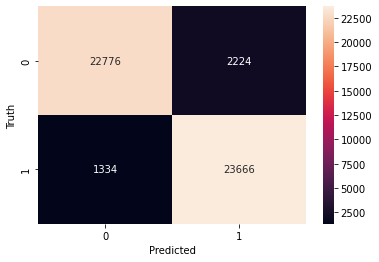

In [23]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [24]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93     25000
           1       0.91      0.95      0.93     25000

    accuracy                           0.93     50000
   macro avg       0.93      0.93      0.93     50000
weighted avg       0.93      0.93      0.93     50000



# Own test

In [25]:
jokes = [
    'What’s the best thing about Switzerland? I don’t know, but the flag is a big plus.',
    'I study Business Informatics at the University of Mannheim!',
    'I invented a new word! Plagiarism!',
    'Did you hear about the mathematician who’s afraid of negative numbers? He’ll stop at nothing to avoid them.',
    'My name is Elias.'
]

jokes_processed = [" ".join(list(tokenizer.convert_ids_to_tokens(tokenizer.encode(i, add_special_tokens=True, max_length=MAX_LEN, truncation=True)))) for i in jokes]

model.predict(jokes_processed)

array([[0.9804497 ],
       [0.68375045],
       [0.849569  ],
       [0.9816421 ],
       [0.98111826]], dtype=float32)